In [1]:
# Import for data manipulation
import pandas as pd 
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ast

from scipy.stats import f_oneway

# import re for regular expression
import re

# scikit-learn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer


# Import package for sentiment analysis
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

In [2]:
# Download for sentiment analysis
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ealopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ealopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Cleaning

In [3]:
df_food = pd.read_csv('food_experiment.csv')
df_food = df_food.drop(columns = 'Timestamp')

In [4]:
df_food = df_food.rename(columns={'What day did you conduct these observations?':'Date Conducted', 
                                  'At which dining hall are you currently located?':'Location',
                                 'During what hours is this dining hall open?':'Location Hours',
                                  'When did you start your observations?':'Experiment Start',
                                 'During what time of the day did you collect information at the dining hall?':'Time of Day',
                                 'What kinds of dishes and materials are currently in use?': 'Dishes in Use',
                                 'What dishes and materials are compostable and/or reusable?':'Sustainable Dishes and Materials',
                                 'Total Number of Subjects Observed ':'Total Subjects',
                                 'About how many subjects took the time to look at the current signage posted by the trash cans?':'Signage Viewer Total',
                                 'About how many subjects properly disposed of food? ("Proper Disposal" - Sorting each item into their respective trash bins.)':'Properly Disposed Total',
                                 'About how many subjects improperly disposed of food? ("Improper Disposal" - Not sorting each item into their respective trash bins.)':'Improperly Disposed Total',
                                 'Observational Trends Noticed While Conducting Study':'Observational Trends',
                                 'When did you conclude your observations?': 'Experiment End'})

In [5]:
df_food.columns

Index(['Date Conducted', 'Location', 'Location Hours', 'Experiment Start',
       'Time of Day', 'Dishes in Use', 'Sustainable Dishes and Materials',
       'Total Subjects', 'Signage Viewer Total', 'Properly Disposed Total',
       'Improperly Disposed Total', 'Observational Trends', 'Experiment End'],
      dtype='object')

## Sentiment Analysis

In [6]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ealopez/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
# TDIF for column 'Observational Trends'
# Begin preprocessing: lowercasing and removing non-alphanumeric characters
trends = df_food['Observational Trends']
trends = [re.sub(r'[^A-Za-z0-9]', ' ', trend) for trend in trends]
trends = [trend.lower() for trend in trends]

In [8]:
# Begin text analysis
tfidf = TfidfVectorizer(analyzer = 'word', 
                        max_features = 2000,
                        tokenizer = word_tokenize,
                        stop_words = stopwords.words("english"))

In [9]:
tfidf_trends_array = tfidf.fit_transform(trends).toarray()
df_trends = pd.DataFrame(tfidf_trends_array)
df_trends.columns = tfidf.get_feature_names()

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
most_unique_instores = df_trends.idxmax(axis = 1)

In [11]:
df_trends = pd.DataFrame(np.sum(df_trends, axis = 0))
df_trends = df_trends.loc['able':]
df_trends_vals = df_trends.loc[:,0]
df_trends['tfidf'] = df_trends_vals
df_trends = df_trends.sort_values(by = 'tfidf', ascending = False)

In [12]:
df_trends = df_trends.loc[:'trays']
df_trends = df_trends.transpose()

**What were the top 20 most common words in responses to the following prompt:**

***"Observational Trends Sample Questions"***

<AxesSubplot:ylabel='Count'>

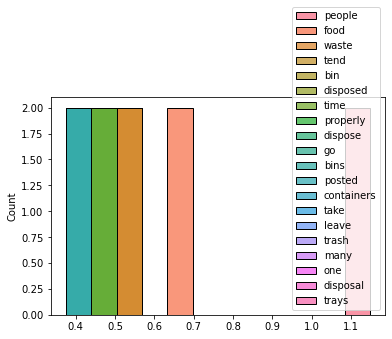

In [13]:
sns.histplot(data = df_trends)

# the word with the highest value is "people" and so on

## Data Setup

In [14]:
df_food = df_food.drop(columns = ['Date Conducted', 'Location Hours', 'Observational Trends'], axis = 1)
df_food

,Location,Experiment Start,Time of Day,Dishes in Use,Sustainable Dishes and Materials,Total Subjects,Signage Viewer Total,Properly Disposed Total,Improperly Disposed Total,Experiment End
0,Warren,7:00:00 PM,Weekend Dinner,"Compostable, Reusable",Glass Dishes\nRed Trays\nPlastic Cups\nTriton ...,61,60,60,1,8:00:00 PM
1,Medical Campus,11:00:00 AM,Lunch Rush,"Compostable, Reusable","Some of the plate, utensils, ect. are reusable...",38,3,32,6,12:00:00 PM
2,Warren,11:00:00 AM,Lunch Rush,Reusable,"the utensils and plates, cups",72,31,44,28,12:16:00 PM
3,Sixth (Lower Dining Hall),11:41:00 AM,"Lunch Rush, Off Hours","Compostable, Reusable, Non-reusable paper cont...","Glass bowls, plastic cups, plastic Triton 2 Go...",26,25,22,4,12:39:00 PM
4,Ocean View Terrace (OVT),11:15:00 AM,Lunch Rush,"Compostable, Reusable",Plastic red trays\nPlastic white bowls\nPaper cup,40,35,35,5,12:20:00 AM
5,Medical Campus,1:15:00 PM,"Lunch Rush, Off Hours","Compostable, Disposable","Paper and cardboard boxes, bowls, cups, and pl...",6,1,0,6,1:55:00 PM
6,Ocean View Terrace (OVT),3:00:00 PM,Off Hours,"Compostable, Reusable","Treys, dishes, ect.",46,5,42,4,4:00:00 PM
7,Sixth (Lower Dining Hall),9:30:00 AM,Breakfast Rush,"Compostable, Reusable","they use reusable trays, utensils, plates, and...",44,12,8,36,11:00:00 AM


### Sixth College

In [15]:
df_sixth = df_food.drop([0, 1, 2, 4, 5, 6]).reset_index()
df_sixth = df_sixth.loc[:,'Total Subjects':'Improperly Disposed Total']

In [16]:
sixth_one = df_sixth.loc[:, 'Total Subjects'].sum(axis = 0)
sixth_two = df_sixth.loc[:, 'Signage Viewer Total'].sum(axis = 0)
sixth_three = df_sixth.loc[:, 'Properly Disposed Total'].sum(axis = 0)
sixth_four = df_sixth.loc[:, 'Improperly Disposed Total'].sum(axis = 0)

### Ocean View Terrace

In [17]:
df_ovt = df_food.drop([0, 1, 2, 3, 5, 7]).reset_index()
df_ovt = df_ovt.loc[:,'Total Subjects':'Improperly Disposed Total']

In [18]:
ovt_one = df_ovt.loc[:, 'Total Subjects'].sum(axis = 0)
ovt_two = df_ovt.loc[:, 'Signage Viewer Total'].sum(axis = 0)
ovt_three = df_ovt.loc[:, 'Properly Disposed Total'].sum(axis = 0)
ovt_four = df_ovt.loc[:, 'Improperly Disposed Total'].sum(axis = 0)

### Medical Campus

In [19]:
df_med = df_food.drop([0, 2, 3, 4, 6, 7]).reset_index()
df_med = df_med.loc[:,'Total Subjects':'Improperly Disposed Total']

In [20]:
med_one = df_med.loc[:, 'Total Subjects'].sum(axis = 0)
med_two = df_med.loc[:, 'Signage Viewer Total'].sum(axis = 0)
med_three = df_med.loc[:, 'Properly Disposed Total'].sum(axis = 0)
med_four = df_med.loc[:, 'Improperly Disposed Total'].sum(axis = 0)

### Warren College

In [21]:
df_warren = df_food.drop([0, 1, 2, 3, 5, 7]).reset_index()
df_warren = df_warren.loc[:,'Total Subjects':'Improperly Disposed Total']

In [22]:
warren_one = df_warren.loc[:, 'Total Subjects'].sum(axis = 0)
warren_two = df_warren.loc[:, 'Signage Viewer Total'].sum(axis = 0)
warren_three = df_warren.loc[:, 'Properly Disposed Total'].sum(axis = 0)
warren_four = df_warren.loc[:, 'Improperly Disposed Total'].sum(axis = 0)

## Student Food Disposal Habits

In [28]:
df_plots = pd.DataFrame({'Total Subjects': [sixth_one,
                                            ovt_one,
                                            med_one,
                                            warren_one],
                       'Signage Viewer Total': [sixth_two,
                                                 ovt_two,
                                                 med_two,
                                                 warren_two],
                       'Properly Disposed Total': [sixth_three,
                                                   ovt_three,
                                                   med_three,
                                                   warren_three],
                       'Improperly Disposed Total': [sixth_four,
                                                     ovt_four,
                                                     med_four,
                                                     warren_four]},
                        index = ['Sixth College', 
                                 'Ocean View Terrace', 
                                 'Medical Campus', 
                                 'Warren College'])

In [42]:
pd.DataFrame(df_plots)

[[                    Total Subjects  Signage Viewer Total  \
  Sixth College                   70                    37   
  Ocean View Terrace              86                    40   
  Medical Campus                  44                     4   
  Warren College                  86                    40   
  
                      Properly Disposed Total  Improperly Disposed Total  
  Sixth College                            30                         40  
  Ocean View Terrace                       77                          9  
  Medical Campus                           32                         12  
  Warren College                           77                          9  ]]

array([<AxesSubplot:ylabel='Total Subjects'>], dtype=object)

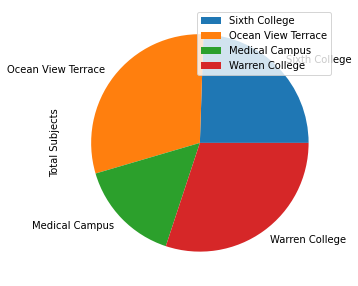

In [36]:
df_plots.plot.pie(y = 'Total Subjects', subplots = True, figsize = (5, 5))

array([<AxesSubplot:ylabel='Signage Viewer Total'>], dtype=object)

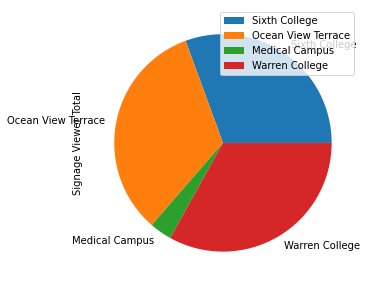

In [37]:
df_plots.plot.pie(y = 'Signage Viewer Total', subplots = True, figsize = (5, 5))

array([<AxesSubplot:ylabel='Properly Disposed Total'>], dtype=object)

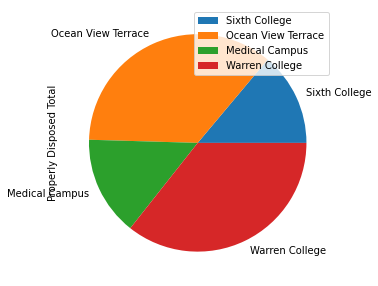

In [38]:
df_plots.plot.pie(y = 'Properly Disposed Total', subplots = True, figsize = (5, 5))

array([<AxesSubplot:ylabel='Improperly Disposed Total'>], dtype=object)

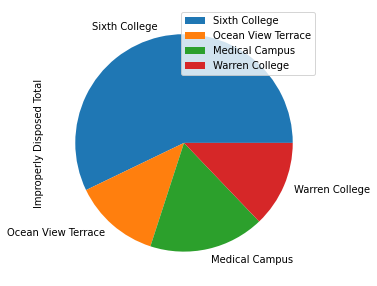

In [39]:
df_plots.plot.pie(y = 'Improperly Disposed Total', subplots = True, figsize = (5, 5))